In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tensorflow
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

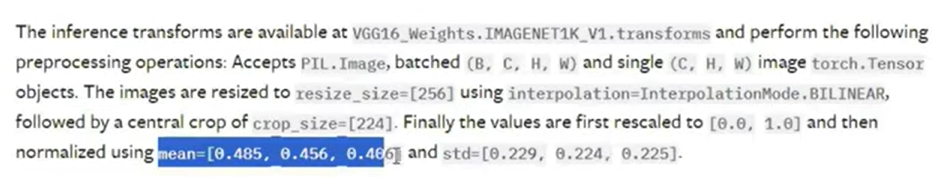


image -> PIL image -> cropping -> normalization -> processed image

In [3]:
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
torch.manual_seed(42)

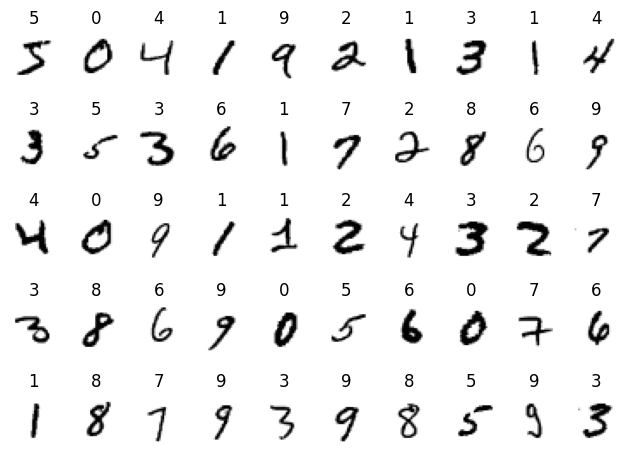

In [6]:
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(Xtrain[i], cmap=plt.cm.binary)
    plt.axis('off')
    plt.title(Ytrain[i])

plt.tight_layout()
plt.show()

In [7]:
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
from PIL import Image

class CustomDataset(Dataset):
  def __init__(self, Xtrain, Ytrain, transforms):
    self.X = Xtrain
    self.Y = torch.tensor(Ytrain, dtype=torch.long)
    self.transform = transforms

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    image = self.X[idx].reshape(28, 28)
    image.astype(np.uint8)
    image = np.stack([image]*3, axis=-1)
    image = Image.fromarray(image)
    image = self.transform(image)
    return image, self.Y[idx]

In [9]:
train_dataset = CustomDataset(Xtrain, Ytrain, custom_transform)
test_dataset = CustomDataset(Xtest, Ytest, custom_transform)

In [10]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [12]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.6MB/s]


In [13]:
# vgg16.features, vgg16.classifier
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
for param in vgg16.features.parameters():
  param.requires_grad = False

In [15]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10),
)

In [16]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
vgg16 = vgg16.to(device)

In [18]:
learning_rate = 0.0001
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
  for batch_x, batch_y in train_loader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    optimizer.zero_grad()
    output = vgg16(batch_x)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

In [ ]:
# evaluation on test data,

In [ ]:
# evaluation on training data